# Handling data with pandas

Pandas is a rich expressive library for analyzing data. Plus it comes with a vast set of utilities. Once you're familiar with what pandas has to offer, you'll be able to do all sorts of data handling tasks by stringing together the right pandas commands.


#### Contents
* [1. Preamble](#1.-Preamble)
* [2. What data looks like](#2.-What-data-looks-like)
  * [2.1 MISSING VALUES](#2.1-MISSING-VALUES)
* [3. Importing, exporting, and creating dataframes](#3.-Importing,-exporting,-and-creating-dataframes)
* [4. Selecting and modifying data](#4.-Selecting-and-modifying-data)
  * [4.1 LIKE A DICTIONARY](#4.1-LIKE-A-DICTIONARY)
  * [4.2 LIKE A DATABASE TABLE](#4.2-LIKE-A-DATABASE-TABLE)
  * [4.3 LIKE AN ARRAY](#4.3-LIKE-AN-ARRAY)
* [5. Tabulations and indexed arrays](#5.-Tabulations-and-indexed-arrays)
  * [5.1 DATAFRAME → INDEXED ARRAY](#5.1-DATAFRAME-→-INDEXED-ARRAY)
  * [5.2 INDEXED ARRAY → DATAFRAME](#5.2-INDEXED-ARRAY-→-DATAFRAME)
* [6. Merging dataframes](#6.-Merging-dataframes)
  * [6.1 WITH DATABASE-STYLE JOINS](#6.1-WITH-DATABASE-STYLE-JOINS)
  * [6.2 WITH PANDAS INDEXING](#6.2-WITH-PANDAS-INDEXING)

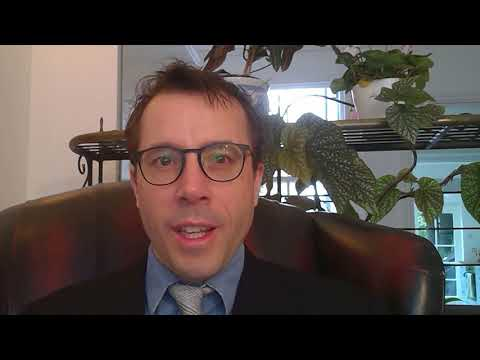

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('hKOkdgv6RkI', width=560, height=315)

## 1. Preamble

At the top of almost every piece of data handling work, we’ll import these standard modules.

In [ ]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

The running example for this section is a dataset of stop-and-search records, [made available by the
UK home office](https://data.police.uk/data/). As it’s a moderate-sized file (172MB) I like to download it to disk, so it’s fast to
reread it each time I restart the notebook. Here’s how we can fetch a file from a url, using the Unix
command-line tool `wget`. (The exclamation mark `!wget` in the code below is called a [Jupyter magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html), and it means “Treat this
line as though it were executed at the command prompt”. In IB Unix Tools you’ll learn more about
the Unix command line.)

In [ ]:
# Execute a unix command to download a file (if it’s not already
# downloaded), and show download progress
import os.path
if os.path.exists('stop-and-search.csv'):
    print("file already downloaded")
else:
    !wget "https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/stop-and-search.csv"

## 2. What data looks like

We almost always work with data in the form of a spreadsheet-like table, referred to as a _dataframe_.
A dataframe is a collection of named columns. Each column has the same length, and all entries in a
column have the same type, though different columns may have different types. Pandas uses numpy
to store columns, so it’s reasonably fast.

Here’s how to load a dataframe from a file using `pandas.read_csv`, and how to inspect it. (This
dataframe will be used as a running example in the rest of this notebook.) The Pandas library is full of
handy utilities like $\textsf{read_csv}$.

In [ ]:
# Import a dataframe using the pandas library
stopsearch = pandas.read_csv('stop-and-search.csv')

# How many rows are there?
print(f"This dataset has {len(stopsearch)} rows")

# What are the columns?
print(stopsearch.columns)

# Display the first 5 rows. iloc[:5] means ”select the first five rows”
# (not all columns fit on this page)
stopsearch.iloc[:5]

### 2.1 MISSING VALUES

Missing values (as in the third entry in the $\textsf{age_range}$ column above) are a fact of life in data science.
They should really be supported by Python itself, but they aren’t, so Pandas adopts its own conventions:
it uses either $\textsf{np.nan}$ (the IEEE floating point for ‘Not A Number’), or $\textsf{None}$ (the built-in Python value
commonly used to denote ‘no return value’). It’s best to use $\textsf{np.nan}$ when the underlying column is a
numpy vector of floating point values, but for other column types it doesn’t matter which is used. To
determine whether values are missing, use `pandas.isna`.

In [ ]:
pandas.isna(stopsearch.age_range[:5]) # returns [False,False,True,False,False]

sum(pandas.isna(stopsearch.age_range)) # count number of missing values

## 3. Importing, exporting, and creating dataframes

In my experience, around 70% of the time you spend working with data will be fighting to import it
and clean it up. See the supplementary notebooks for a collection of recipes for web scraping, reading from a
database, and parsing log files.

The simplest case is when you have a nice simple comma-separated value (CSV) file. A CSV file looks like
this:
```
"Sepal.Length","Sepal.Width","Petal.Length","Petal.Width","Species"
5.1,3.5,1.4,0.2,"setosa"
4.9,3,1.4,0.2,"setosa"
4.7,3.2,1.3,0.2,"setosa"
4.6,3.1,1.5,0.2,"setosa"
5,3.6,1.4,0.2,"setosa"
```
i.e. a header line, then one line per row of the data frame, with values separated by commas. We’ve
already seen how to import a CSV, using [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html). If your file is nearly a CSV but has some
quirks such as comments or a missing header row, experiment with that function’s 55 options. We can
use the same function to read CSV files from remote url:

In [ ]:
url = 'https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/iris.csv'
iris = pandas.read_csv(url)

To write a CSV file,

In [ ]:
iris.to_csv('iris.csv', index=False)

To create a dataframe from scratch, pass in a dictionary of columns. You can optionally specify the column order you want with the columns argument.

In [ ]:
iris = pandas.DataFrame({
'species': ['setosa', 'virginica', 'virginica', 'setosa', 'versicolor'],
'Petal.length': [1.0, 5.0, 5.8, 1.7, 4.2],
'Petal.width': [0.2, 1.9, 1.6, 0.5, 1.2]
},
columns = ['Petal.length', 'Petal.width', 'species'])

Or you can create a dataframe from a list of tuples. Now the columns argument is needed to say what
the column names are.

In [ ]:
iris = pandas.DataFrame([
('setosa', 1.0, 0.2), ('virginica', 5.0, 1.9), ('virginica', 5.8, 1.6),
('setosa', 1.7, 0.5), ('versicolor', 4.2, 1.2)
],
columns = ['species', 'Petal.length', 'Petal.width'])

## 4. Selecting and modifying data

Data frames have a triple identity:
* they’re like a dictionary, where the keys are column names and the values are numpy vectors,
and we can add, modify, or remove entire columns
* they’re like a database table, and we can select subtables by row and/or column
* they’re like an array, and we can select parts of the dataframe based on row indexes.

### 4.1 LIKE A DICTIONARY

We can access entire columns as though the dataframe is a dictionary.

In [ ]:
stopsearch.columns          # get a list of column names
stopsearch.keys()           # … and another way to do the same
x = stopsearch['outcome']   # get a single column
x = stopsearch.outcome      # … and another way to do the same
del stopsearch['location']  # delete a column
# add or modify a column
stopsearch['outcome_N'] = np.where(stopsearch.outcome == 'False', 0, 1)

The columns aren't just numpy vectors, they're pandas [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) objects. They support many additional real-world data-handling operations that are missing from plain numpy. For example
* `Series.str.startswith` and [many other vectorized string operations](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#api-series-str)
* Convert strings to timestamps with [`pandas.to_datetime`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) and then use the [many datetime operations](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#api-series-dt)
* [`Series.replace`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.replace.html) to replace elements, as shown below

In [ ]:
# list all the non-NA values, and their counts
stopsearch['age_range'].value_counts()    
# replace all the string age-ranges with numbers
r = {'18-24':21.5, '10-17':14, '25-34':30, 'over 34':40, 'under 10':8}
stopsearch['age'] = stopsearch['age_range'].replace(r)

### 4.2 LIKE A DATABASE TABLE

We can obtain a new dataframe by selecting a subset of rows and/or columns,
using `.loc`.

In [ ]:
stopsearch.loc[:, ['force','datetime','outcome']]  # all rows, some cols
stopsearch[['force','datetime','outcome']]         # … the same thing
stopsearch.loc[stopsearch.force=='cambridgeshire'] # some rows, all cols
stopsearch.loc[stopsearch.force=='cambridgeshire', # some rows, some cols
               ['force','datetime','outcome']]

If we want to select rows by row number, rather than by a boolean condition as above, we need .iloc.

In [ ]:
stopsearch.iloc[:3]      # the first 3 rows
stopsearch[:3]           # … and another way to do the same
stopsearch.iloc[[0,3,5]] # select several rows
stopsearch.iloc[[5]]     # returns a one-row dataframe
stopsearch.sample(4)     # select 4 rows at random

Row and column selectors can be combined.

In [ ]:
wantcols = ['force','datetime','outcome']
stopsearch.loc[stopsearch.force=='cambridgeshire', wantcols]
stopsearch[wantcols].iloc[:3]
stopsearch.loc[stopsearch.force=='cambridgeshire', wantcols].iloc[:3]

To pull out a single row as a tuple, or to pull out a single value as a scalar, there is different syntax.

In [ ]:
stopsearch['force'].iat[5] # a scalar for the specified column and row
stopsearch.iloc[5]         # a tuple containing the values for row 5

We can use these indexing operations to update a specific element in the dataframe—but  I think
it’s cleaner to modify data using dictionary indexing, replacing an entire column, rather than hacking
at individual elements.

Sometimes pandas will tell us off, warning us that the operation may be inefficient.

In [ ]:
stopsearch['outcome_N'][0] = 2

<pre style="color:red">
SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame
</pre>

This means that we've taken a subset of the rows, and tried to set a variable. Pandas doesn't actually copy the dataframe when you take a subset of the rows, it shares the data with the original table. So, to suppress this warning, take a copy of the dataframe with `df=stopsearch.copy()`, and then modify
the copy.

### 4.3 LIKE AN ARRAY

There is a third way to select rows from a dataframe, which in my experience is the
source of endless confusion: selecting by row index. When you see a Pandas dataframe printed out,
there is a column at the left without a column name. These aren’t row numbers, they are row indexes,
which behave like the keys in a dictionary. In all the examples we’ve seen so far the indexes happen
to be numbers, but they could be any other Python object. Row indexes are there for the same reason
database tables have indexes: they’re vital for efficient lookup. But we won’t be using them in this
course.

Pandas always keeps track of row indexes. Even when you pull out a single column, it doesn't give us a numpy vector, it gives us a Series object which is numpy-vector-plus-indexes.
And it always tries to match indexes.
This is usually not what we want, especially when we just want some plain simple arithmetic. **I recommend that you generally use `.values`
when you are working with subsets of rows.** This gives you the actual numpy vector behind the
column, not the confusing Series. We won’t be taking advantage of row
indexes in this course, but it’s worth knowing they exist so you can understand the cryptic errors and
error messages you will undoubtedly come across.

In [89]:
df = pandas.DataFrame({'x': [3,3,4,8,2]}, index=['a','b','c','d','e'])

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>x</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>a</th>
      <td>3</td>
    </tr>
    <tr>
      <th>b</th>
      <td>3</td>
    </tr>
    <tr>
      <th>c</th>
      <td>4</td>
    </tr>
    <tr>
      <th>d</th>
      <td>8</td>
    </tr>
    <tr>
      <th>e</th>
      <td>2</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
# This looks like it should add [3,3,4] and [4,8,2] … but it doesn’t!
df['x'][:3] + df['x'][2:]

<pre>a    NaN
b    NaN
c    8.0
d    NaN
e    NaN
Name: x, dtype: float64</pre>

In [ ]:
# To get the answer we were probably expecting,
df['x'][:3].values + df['x'][-3:].values

<pre>array([ 7, 11,  6])</pre>

## 5. Tabulations and indexed arrays

The pattern behind much data processing is split-apply-combine-join: split your data into pieces, apply
a transformation to each piece, combine the pieces, and join results from different datasets together.
We could code this explicitly with a ‘for’ loop, but it would involve lots of boilerplate code — and I
hope you have been persuaded by the [NumPy notes](notes2_numpy.ipynb#2.3-FOR-LOOPS-CONSIDERED-HARMFUL) that ‘for’ loops are considered harmful. Instead, let’s
see how to do it with Pandas.

### 5.1 DATAFRAME → INDEXED ARRAY

The following line of code performs a cross-tabulation: it splits the data into a separate dataframe
for each combination of officer-defined ethnicity and gender, applies the `len` function to each subdataframe
to get the number of rows it contains, and combines the results into a single indexed object.

* If we want to apply the function to a single column, pick it out after the groupby.

* If we want to apply a more elaborate function, it's handy to define an anonymous function with `lambda`.

In [84]:
# Select cambridgeshire records, then tabulate by ethnicity and gender
df = stopsearch.loc[stopsearch.force=='cambridgeshire']
x = df.groupby(['officer_defined_ethnicity', 'gender']).apply(len)

<pre>officer_defined_ethnicity  gender
Asian                      Female       7
                           Male       179
                           Other        1
Black                      Female      10
                           Male       257
Other                      Female       6
                           Male        28
White                      Female     253
                           Male      1465
                           Other        5
dtype: int64</pre>

In [ ]:
# Apply the np.mean function to the 'age' column, separately for each gender
# (This assumes you've run the commands in 4.1 to define the age column, before defining df.)
df.groupby('gender')['age'].apply(lambda x: np.mean(x))

<pre>gender
Female    24.656682
Male      24.628913
Other     24.750000
Name: age, dtype: float64</pre>

For this course, we will only apply functions that return simple Python values. It’s [possible but more
complicated](http://pandas.pydata.org/pandas-docs/stable/groupby.html) to apply functions that return dataframes or Pandas columns or indexed arrays.

The groupby/apply commands have produced an _indexed array_. An indexed array is a cross between a
normal numpy array and a dataframe. We access elements and sub-arrays by dimension, like a numpy
array — but the indexes aren’t integer positions, they’re values from the underlying column. Also, the
array might be ‘incomplete’, as in the example above which has no entry for $\textsf{['Black','Other']}$.

In [ ]:
x.loc['Asian']           # select the sub-array of ethnicity Asian
x.loc[:, 'Other']        # select the sub-array of gender Other
x.loc[['Black','White']] # select two ethnicities, all genders

The index labels can be accessed with `x.index.levels[0].values` and `x.index.levels[1].values`.
To pretty-print an indexed array, use [unstack](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.unstack.html). It will by default fill in any missing values with $\textsf{NaN}$
(not a number), and you can override this with $\textsf{fill_value}$.

In [ ]:
x.unstack(fill_value=0)

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>gender</th>
      <th>Female</th>
      <th>Male</th>
      <th>Other</th>
    </tr>
    <tr>
      <th>officer_defined_ethnicity</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Asian</th>
      <td>7</td>
      <td>179</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Black</th>
      <td>10</td>
      <td>257</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Other</th>
      <td>6</td>
      <td>28</td>
      <td>0</td>
    </tr>
    <tr>
      <th>White</th>
      <td>253</td>
      <td>1465</td>
      <td>5</td>
    </tr>
  </tbody>
</table>
</div>

### 5.2 INDEXED ARRAY → DATAFRAME

There are two ways to convert an indexed array to a dataframe, depending on the shape of the dataframe
you want to end up with.

In [ ]:
# Convert an indexed array into a long-form dataframe
# -- the array values will become a column, and we can specify its name
x[['Black','White']].reset_index(name='count')

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>officer_defined_ethnicity</th>
      <th>gender</th>
      <th>count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Black</td>
      <td>Female</td>
      <td>10</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Black</td>
      <td>Male</td>
      <td>257</td>
    </tr>
    <tr>
      <th>2</th>
      <td>White</td>
      <td>Female</td>
      <td>253</td>
    </tr>
    <tr>
      <th>3</th>
      <td>White</td>
      <td>Male</td>
      <td>1465</td>
    </tr>
    <tr>
      <th>4</th>
      <td>White</td>
      <td>Other</td>
      <td>5</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
# Convert an indexed array into a wide-form dataframe.
# (I'm using the line-continuation character "\" so my code isn't a confusing one-liner)
x[['Black','White']].unstack(fill_value=0) \
.reset_index() \
.rename_axis(None, axis=1)

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>officer_defined_ethnicity</th>
      <th>Female</th>
      <th>Male</th>
      <th>Other</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Black</td>
      <td>10</td>
      <td>257</td>
      <td>0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>White</td>
      <td>253</td>
      <td>1465</td>
      <td>5</td>
    </tr>
  </tbody>
</table>
</div>

When you first start working with data, I recommend you do all your calculations on dataframes rather
than indexed arrays. If you want to do calculations on an indexed array, first turn it into a dataframe.
As you get deeper into working with data, you’ll discover that the skill in working with data is knowing
which representation works best for your task, dataframe or indexed array. Also,

* Pandas blurs the boundary between dataframes and indexed arrays
* Both rows and columns can have hierarchical indexes, called [multi-indexes](https://pandas.pydata.org/pandas-docs/stable/advanced.html)
* For clever tricks with higher-dimensional indexed arrays, read the documentation for [unstack](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.unstack.html)
and [rename_axis](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename_axis.html).
* When you read the documentation or look for help, please note that what I’m calling an indexed
array, Pandas calls a [Series](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

## 6. Merging dataframes

When processing data we often want to combine data at different levels of aggregation. For example,
we might like to compare the frequency of false stops (i.e. where the police stopped someone and found
nothing suspicious) across different ethnicities. Here’s how we prepare the first three columns … but
what about the $n_\text{tot}$ column and $n/n_\text{tot}$?

In [ ]:
df = stopsearch.loc[stopsearch.force=='cambridgeshire'].copy()
df['outcome'] = np.where(df.outcome == 'False', 'nothing', 'find')
x = df.groupby(['officer_defined_ethnicity', 'outcome']) \
.apply(len) \
.reset_index(name='n')

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>officer_defined_ethnicity</th>
      <th>outcome</th>
      <th>n</th>
        <th>n<sub>tot</sub></th>
        <th>n / n<sub>tot</sub></th>
    </tr>
  </thead>
  <tbody>
    <tr style="background: #f5f5f5;">
      <th>0</th>
      <td>Asian</td>
      <td>find</td>
      <td>116</td>
        <td rowspan=2>192</td>
        <td>60.4%</td>
    </tr>
    <tr style="background: #f5f5f5;">
      <th>1</th>
      <td>Asian</td>
      <td>nothing</td>
      <td>76</td>
        <td>39.6%</td>
    </tr>
    <tr style="background: white;">
      <th>2</th>
      <td>Black</td>
      <td>find</td>
      <td>170</td>
        <td rowspan=2>270</td>
        <td>63.0%</td>
    </tr>
    <tr style="background: white;">
      <th>3</th>
      <td>Black</td>
      <td>nothing</td>
      <td>100</td>
        <td>37.0%</td>
    </tr>
    <tr style="background: #f5f5f5;">
      <th>4</th>
      <td>Other</td>
      <td>find</td>
      <td>28</td>
        <td rowspan=2>37</td>
        <td>75.7%</td>
    </tr>
    <tr style="background: #f5f5f5;">
      <th>5</th>
      <td>Other</td>
      <td>nothing</td>
      <td>9</td>
        <td>24.3%</td>
    </tr>
    <tr style="background: white;">
      <th>6</th>
      <td>White</td>
      <td>find</td>
      <td>1060</td>
        <td rowspan=2>1740</td>
        <td>60.9%</td>
    </tr>
    <tr style="background: white;">
      <th>7</th>
      <td>White</td>
      <td>nothing</td>
      <td>680</td>
        <td>30.1%</td>
    </tr>
  </tbody>
</table>
</div>

### 6.1 WITH DATABASE-STYLE JOINS

The database answer is to create a smaller table with two columns, $\textsf{officer_defined_ethnicity}$ and $n_\text{tot}$,
and then to join this to $\textsf{x}$ using the key $\textsf{officer_defined_ethnicity}$.

In [ ]:
y = x.groupby('officer_defined_ethnicity')['n'].apply(sum).reset_index(name='ntot')

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>officer_defined_ethnicity</th>
      <th>ntot</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Asian</td>
      <td>192</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Black</td>
      <td>270</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Other</td>
      <td>37</td>
    </tr>
    <tr>
      <th>3</th>
      <td>White</td>
      <td>1740</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
z = x.merge(y, on='officer_defined_ethnicity')
p = z.n / z.ntot
z['percent_find'] = np.round(p * 100, 1)
# Also compute a margin for error; see IB Data Science for the theory
z['err'] = np.round(1.96 * np.sqrt(p*(1-p)/z.ntot) * 100, 1)

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>officer_defined_ethnicity</th>
      <th>outcome</th>
      <th>n</th>
      <th>ntot</th>
      <th>percent_find</th>
      <th>err</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Asian</td>
      <td>find</td>
      <td>116</td>
      <td>192</td>
      <td>60.4</td>
      <td>6.9</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Asian</td>
      <td>nothing</td>
      <td>76</td>
      <td>192</td>
      <td>39.6</td>
      <td>6.9</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Black</td>
      <td>find</td>
      <td>170</td>
      <td>270</td>
      <td>63.0</td>
      <td>5.8</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Black</td>
      <td>nothing</td>
      <td>100</td>
      <td>270</td>
      <td>37.0</td>
      <td>5.8</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Other</td>
      <td>find</td>
      <td>28</td>
      <td>37</td>
      <td>75.7</td>
      <td>13.8</td>
    </tr>
    <tr>
      <th>5</th>
      <td>Other</td>
      <td>nothing</td>
      <td>9</td>
      <td>37</td>
      <td>24.3</td>
      <td>13.8</td>
    </tr>
    <tr>
      <th>6</th>
      <td>White</td>
      <td>find</td>
      <td>1060</td>
      <td>1740</td>
      <td>60.9</td>
      <td>2.3</td>
    </tr>
    <tr>
      <th>7</th>
      <td>White</td>
      <td>nothing</td>
      <td>680</td>
      <td>1740</td>
      <td>39.1</td>
      <td>2.3</td>
    </tr>
  </tbody>
</table>
</div>

### 6.2 WITH PANDAS INDEXING

This particular operation (groupby and apply, then merge the result back into the original table) is so common that pandas has a built-in way to do it, using `df.groupby(...)[col].transform(f)`. This applies function $\textsf{f}$ to each chunk of $\textsf{col}$, and then reassembles the answer back into an array _with the same index as $\textsf{df}$_. We can then just put it into $\textsf{df}$ as an extra column.

In [ ]:
x['ntot'] = x.groupby('officer_defined_ethnicity')['n'].transform(sum)

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>officer_defined_ethnicity</th>
      <th>outcome</th>
      <th>n</th>
      <th>ntot</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Asian</td>
      <td>find</td>
      <td>116</td>
      <td>192</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Asian</td>
      <td>nothing</td>
      <td>76</td>
      <td>192</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Black</td>
      <td>find</td>
      <td>170</td>
      <td>270</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Black</td>
      <td>nothing</td>
      <td>100</td>
      <td>270</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Other</td>
      <td>find</td>
      <td>28</td>
      <td>37</td>
    </tr>
    <tr>
      <th>5</th>
      <td>Other</td>
      <td>nothing</td>
      <td>9</td>
      <td>37</td>
    </tr>
    <tr>
      <th>6</th>
      <td>White</td>
      <td>find</td>
      <td>1060</td>
      <td>1740</td>
    </tr>
    <tr>
      <th>7</th>
      <td>White</td>
      <td>nothing</td>
      <td>680</td>
      <td>1740</td>
    </tr>
  </tbody>
</table>
</div>

Pandas also lets us join indexed arrays on their common indices, and that can often streamline more advanced database-style joins; but that counts as more advanced Pandas usage than we will cover here.